In [41]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
from models import *
import torch
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


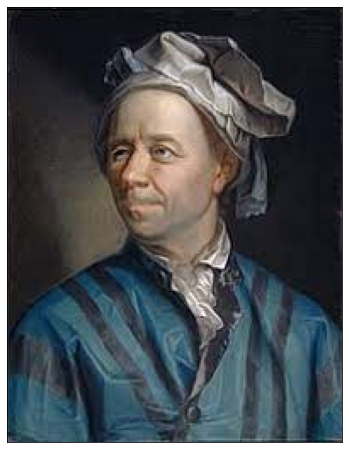

In [42]:
rgb = image.imread("euler.jpg")
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(rgb)
lines, columns = rgb.shape[:-1]

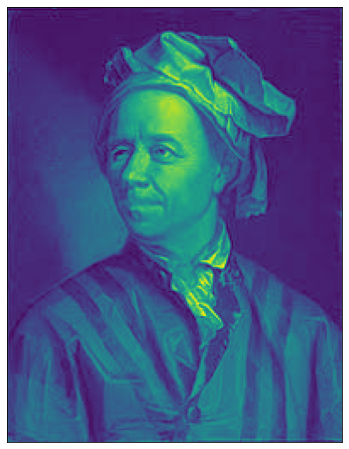

In [43]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(grey)
filename_png = 'euler_gray_scale.png'
figure.savefig(filename_png, bbox_inches='tight', pad_inches=0)

In [83]:
#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 100000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples//columns + torch.rand(num_samples))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1)], dim = -1)

C:\Users\EA264728\AppData\Local\Temp/ipykernel_12200/4025941441.py:8: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([((categorical_samples//columns + torch.rand(num_samples))/lines).unsqueeze(-1), ((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1)], dim = -1)


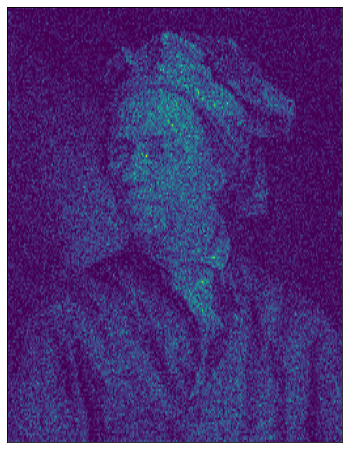

In [84]:
hist_target_samples, x_edges, y_edges = np.histogram2d(target_samples[:,1].numpy(), target_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [85]:
K=50
EM = EMDensityEstimator(target_samples,K)
EM.train(100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s, loss = -0.13822902739048004]


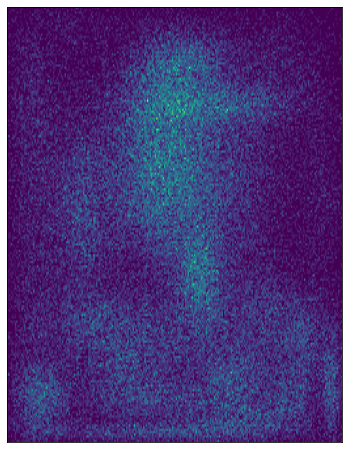

In [86]:
proposed_samples, labels = EM.sample_joint([num_samples])
hist_target_samples, x_edges, y_edges = np.histogram2d(proposed_samples[:,1].numpy(), proposed_samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_target_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [87]:
labels = torch.cat([K*torch.ones(num_samples).int(),labels])
samples = torch.cat([target_samples, proposed_samples], dim=0)

In [ ]:
multi_classif = classifier(K+1,samples, labels, hidden_dims = [256,256,256])
multi_classif.train(1000, lr=5e-3)
density_ratio = lambda samples : torch.exp(multi_classif.model.log_prob(samples))[:,-1]/torch.sum(torch.exp(multi_classif.model.log_prob(samples))[:,:-1], dim = -1)

 50%|███████████████████████████████████████████████████████▌                                                      | 505/1000 [4:41:39<23:31,  2.85s/it, loss = 316803.1562; device = cpu]

In [51]:
from tqdm import tqdm
def run_approx_IMH(number_steps, proposal, number_chains):
    state = proposal.sample([number_chains])
    for _ in tqdm(range(number_steps)):
        proposed_samples = proposal.sample([number_chains])
        acceptance_log_prob = torch.log(density_ratio(proposed_samples)) - torch.log(density_ratio(state))
        mask = ((torch.rand(state.shape[0]) < torch.exp(acceptance_log_prob)) * 1.).unsqueeze(-1)
        state = (mask)*proposed_samples + (1-mask)*state
    return state

In [53]:
samples = run_approx_IMH(200,EM, 100000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [08:08<00:00,  2.44s/it]


In [89]:
from torch.distributions import Categorical
def resample_dependant(x):
    ratio = density_ratio(x)
    proba = ratio/torch.sum(ratio)
    pick = Categorical(proba).sample([x.shape[0]])
    return x[pick,:]

proposed_samples = EM.sample([300000])
accepted = resample_dependant(proposed_samples)

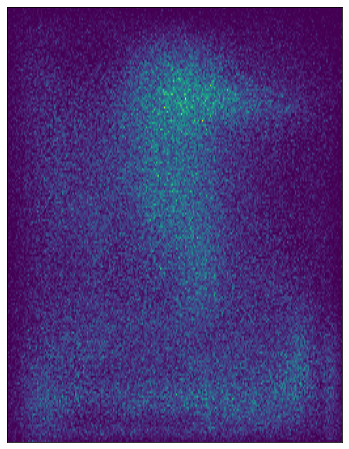

In [90]:
hist_accepted_samples, x_edges, y_edges = np.histogram2d(accepted[:,1].numpy(), accepted[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
figure = plt.figure(figsize = (12,8))
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_accepted_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])

In [ ]:
plt.scatter(q_samples[:5000,0], q_samples[:5000,1], color ='blue', alpha =0.3)
plt.scatter(target_samples[:5000,0], target_samples[:5000,1], color = 'red', alpha=0.3)
plt.show()

In [ ]:
import matplotlib
def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 200, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)
        plt.legend()
    
plot_2d_function(lambda samples :torch.sigmoid(classif.logit_r(samples)), x_min = 0, x_max = 1 , y_min =0, y_max = 1, levels = 100)

In [ ]:
from torch import nn 
from tqdm import tqdm
class LARS_DE(nn.Module):
    def __init__(self,target_samples, hidden_dims):
        super().__init__()
        self.target_samples = target_samples
        self.p = target_samples.shape[-1]
        
        network_dimensions = [self.p] + hidden_dims + [1]
        network = []
        for h0, h1 in zip(network_dimensions, network_dimensions[1:]):
            network.extend([nn.Linear(h0, h1), nn.SiLU(), ])
        network.pop()
        network.extend([nn.LogSigmoid(),])
        
        self.log_alpha = nn.Sequential(*network)
        self.proposal = torch.distributions.MultivariateNormal(torch.mean(target_samples, dim=0), torch.cov(target_samples.T))
        self.loss_values = []
        
    def sample(self, num_samples):
        proposed_samples = self.proposal.sample([num_samples])
        acceptance_probability = torch.exp(self.log_alpha(proposed_samples)).squeeze(-1)
        mask = torch.rand(acceptance_probability.shape)<acceptance_probability
        return proposed_samples[mask]
    
    def estimate_log_constant(self, num_samples):
        proposed_samples = self.proposal.sample([num_samples])
        self.log_constant = torch.logsumexp(self.log_alpha(proposed_samples).squeeze(-1), dim = 0) - torch.log(torch.tensor([proposed_samples.shape[0]]))
    
    def log_prob(self, x, num_samples = 1000):
        return self.proposal.log_prob(x) + self.log_alpha(x).squeeze(-1) - self.log_constant
    
    def loss(self,target_samples):
        loss = -torch.mean(self.log_prob(target_samples))
        return loss
    
    def train(self, epochs, batch_size=None):
        self.para_list = list(self.parameters())
        self.optimizer = torch.optim.Adam(self.para_list, lr=5e-3)
        if batch_size is None:
            batch_size = self.target_samples.shape[0]
        dataset = torch.utils.data.TensorDataset(self.target_samples)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        pbar = tqdm(range(epochs))
        for t in pbar:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, batch in enumerate(dataloader):
                x = batch[0].to(device)
                self.optimizer.zero_grad()
                self.estimate_log_constant(self.target_samples.shape[0])
                batch_loss = self.loss(x)
                batch_loss.backward()
                self.optimizer.step()
            with torch.no_grad():
                iteration_loss = torch.tensor([self.loss(batch[0].to(device)) for i, batch in enumerate(dataloader)]).mean().item()
                self.loss_values.append(batch_loss)
            pbar.set_postfix_str('loss = ' + str(round(iteration_loss,6)))
        self.to(torch.device('cpu'))
lars_de = LARS_DE(target_samples,[64,64,64])
lars_de.train(100, 10000)
samples = lars_de.sample(10000)
plt.scatter(samples[:,0].numpy(), samples[:,1].numpy())
#plot_2d_function(lambda samples :torch.exp(lars_de.log_prob(samples)), levels = 20, delta = 200) 

In [ ]:
samples = lars_de.sample(1000000)
print(samples.shape)

In [ ]:
hist_accepted_samples, x_edges, y_edges = np.histogram2d(samples[:,1].numpy(), samples[:, 0].numpy(), bins = (lines, columns),range = [[0, 1],[0,1]])
plt.imshow(torch.flip(torch.flip(torch.tensor(hist_accepted_samples).T,[0,1]),[0,1]),extent = [0,columns,0, lines])